In [2]:
%matplotlib inline 
from kf_book.gh_internal import plot_g_h_results
from kf_book.gh_internal import book_plots
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from numpy.random import randn
import numpy as np


# GHK-Filter
---
    这一节，主要介绍GHK-Filter的主要思想，也是Kalman-Filter的基本思想。
    即：由初始状态预估下一状态，与测量值相对比，按照一定程度置信度，加权获得下一状态的实际估计值。
    
    这个想法里面，我们可以发现这几点：
1. 我们需要这些数据：
    - 初始状态数据
    - 实时状态测量数据
    - 获取下一状态的加权系数
2. 我们需要考虑，如何预估下一状态，即：先验假设
3. 我们需要考虑，如何分配预估值和测量值对下一状态实际估计值的加权比重，即：后验假设
    
    

- ### 初始数据
    
       在第一个问题（初始数据）中，我们不难想到，我们可以把任何一个需要估计的阶段的开始认为是状态零点，即：
$$ x= \left\lgroup \matrix{x \cr \dot x} \right\rgroup = \left\lgroup \matrix{0 \cr 0} \right\rgroup $$
    
比如说：我们在使用手机上的记录跑步行程的软件的时候，我们总是可以选定开始的时间，开始的地点，也就是你开始使用的时间与地点，然后记录下来我们整个跑步行程。在这里我们的初始数据，就记为状态 $x=0$。

        此外，我们还可以想到，初始状态为一个确定的值的状态，他不一定是固定的，但是我们一定可以知道他开始的状态是什么，即：
$$ x= \left\lgroup \matrix{x \cr \dot x} \right\rgroup = \left\lgroup \matrix{x_0 \cr \dot x_0} \right\rgroup $$

比如说：一架歼-31战斗机从一艘某型号航空母舰上起飞，那么他起飞前就已经有了初始速度，即航空母舰相对于海风的速度，而这些速度是我们已知的，那么我们在估计歼-31的离舰速度就可以使用有初始状态的初始数据假设了。（*题外话，当然真实情况下不会采用这么简单的方式估计，至少是多模融合的*）

        再者，我们还可以想到，初始状态是无法确定的，这种情况也是比较常见的，而因此，我们通常就取更加相信测量值的值作为初始状态，即：
$$ x= \left\lgroup \matrix{x \cr \dot x} \right\rgroup = \left\lgroup \matrix{z_0 \cr \dot z_0} \right\rgroup + randn()$$

<font face='楷体', color=gray, size=2> 当然，在这里`randn()`也可以省略</font> 


- ### 测量数据

        实时状态的测量数据，通常就是我们测量系统所输入的测量值。由于计算机擅长于离散信号的计算，所以滤波器通常接收到的信号都使离散信号，而离散信号可以是，信号本身就是离散的，比如说电影、音乐等人造信号或经过记录存储的信号，也有信号本身是连续的，但为了处理而经过了采样过程，比如说，压力、温度等有物理信息直接转化为电信号的信号。
        在本文中，由于是对理论的一种探讨，所以省略了，连续信号采样过程，甚至离散信号的接受过程，这一部分的内容可以在大多数的信号预处理的书籍文献中获取，应该说，滤波器是信号处理问题中细化了的一部分内容，同时他和控制算法结合紧密，所以Dr.Kalman建立了KalmanFilter标志现代控制理论的成熟。    
接下来我们给一段白噪声的模型：


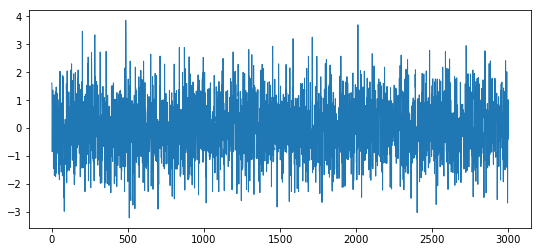

In [8]:
# 生成随机白噪声
x=[randn() for _ in range(3000)]
plt.plot(x,lw=1)


## [加性高斯白噪声](https://zh.wikipedia.org/zh-hans/加性高斯白噪声)

**加性高斯白噪声**（英语：Additive white Gaussian noise，AWGN）在通信领域中指的是一种功率谱函数是常数（即[白噪声](https://www.wikiwand.com/zh-hans/%E7%99%BD%E9%9B%9C%E8%A8%8A)），且幅度服从高斯分布的噪声信号。因其可加性、幅度服从高斯分布且为白噪声的一种而得名。

该噪声信号为一种便于分析的理想噪声信号，实际的噪声信号往往只在某一频段内可以用高斯白噪声的特性来进行近似处理。由于AWGN信号易于分析、近似，因此在信号处理领域，对信号处理系统（如滤波器、低噪音高频放大器、无线信号传输等）的噪声性能的简单分析(如：信噪比分析)中，一般可假设系统所产生的噪音或受到的噪音信号干扰在某频段或限制条件之下是高斯白噪声。

加性高斯白噪声只是白噪声的一种，另有[泊松白噪声](http://www.jianshu.com/p/67f909f3d0ce)等。

来自[![wikipedia](https://upload.wikimedia.org/wikipedia/commons/7/7a/Nohat-wiki-logo.png)](https://www.wikipedia.org/)


- ### 先验假设

        先验假设，即由当前状态值估计接下来的状态，其估计方法为，在当前状态上加上含有不确定性的过程值，这个过程值通常就是位置变化的速度在采样时间内发生的位移，即：
$$ x_{k+1}^{i}= x_{k}^{k} + \dot x_{k}^{k}dt + randn()$$

        这个不确定性，主要由当前状态不确定和过程变化不确定造成，具有线性累加性质。即：
$$ P_{k+1}^{i} = FP_{k}^{k}F^{T} + Q $$ 

其中，`Q`是过程不确定，$x_{k}^{k}$是当前k时状态量，$P_{k}^{k}$是当前k时状态不确定，`F`是系统传递函数  


- ### 后验假设

        后验假设，是在先验假设的预估计值的基础上，依托对测量值的参考，选取一定的加权系数，修正参考差值并加于预估值上，得到最终估计值。即：
$$ x_{k+1}^{k+1} = x_{k+1}^{k} + K(z_{k+1} - x_{k+1}^{k}) $$

$$ P_{k+1}^{k+1} = P_{k+1}^{k} - KHP_{k+1}^{k} $$

需要说明的是，此处`K`就是权系数，`H`是状态量匹配于测量量的系数（以后会说到），$x_{k+1}^{k+1}$是k时下一状态量， $P_{k+1}^{k+1}$是k时下一状态不确定


- ### 权系数

        需要说明，此前所讲述的部分是线性KalmanFilter的基本内容，GHKFilter与它的区别也是在此处存在。GHKFilter的权系数是定常值，其包含g、h、k三个参数，分别对应于修正广义位移、广义速度、广义加速度。因此，GHKFilter具有全局不可变性，它的应变能力显得差一些。
        
以下是一个例子：*本例中，为了简化，将加速度设为0*


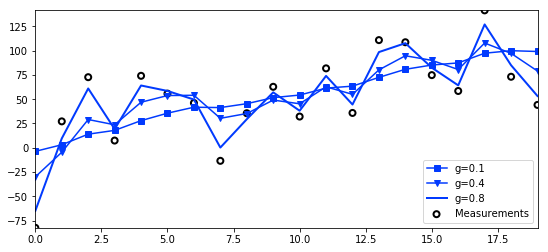

In [7]:
#定义GHfilter过程函数
def g_h_filter(data, x0, dx, g, h, dt=1.):
    x_est = x0
    results = []
    for z in data:
        #prediction step
        x_pred = x_est + (dx*dt)
        dx = dx

        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual     
        results.append(x_est)  
    return np.array(results)


#定义数据生成函数，实际上，这就是现实生活之中，传感器所测量得到的数据，由于存在白噪声，此处就拟合生成了一个存在白噪声的信号
def gene_data(x0, dx, count, noise_factor, accel=0.):
    z=[]
    for i in range(count):
        z.append(x0 + dx*i + randn()*noise_factor)
        dx += accel
    return np.array(z)


np.random.seed(100)



#获得数据的测量值数组，数据生成由：确信的初始位置x0、速度dx，过程加速度accel、位置噪音系数noise_factor。
measurements = gene_data(x0=5., dx=5., count=20, noise_factor=50, accel=0.) 

#获得三组不同GHfilter的估计值数组，数据生成由：测量值，确信的初始位置x0、速度dx，采样时间dt，以及滤波器性能参数 g、h
data1 = g_h_filter(data=measurements, x0=0., dx=5., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=measurements, x0=0., dx=5., dt=1., g=0.4, h=0.01)
data3 = g_h_filter(data=measurements, x0=0., dx=5., dt=1., g=0.8, h=0.01)

#画图
with book_plots.figsize(y=4):
    book_plots.plot_measurements(measurements, lw=1, color='k')
    book_plots.plot_filter(data1, label='g=0.1', marker='s')
    book_plots.plot_filter(data2, label='g=0.4', marker='v')
    book_plots.plot_filter(data3, label='g=0.8', lw=2)
    plt.legend(loc=4)
    #book_plots.set_limits([20,40], [50, 250]) #g=0.2 and h=0.02, initial gusse for x to be 5
#plot_g_h_results(measurements, data)


<font face='楷体',size=4>我们可以由图发现，当参数g不断增大的时候，滤波器更加偏向于相信测量值，而此时测量值的噪音相比于预估计较大，因此，g越大越不好。同理，h也有类似于广义速度的特性，可以自行玩玩。</font>


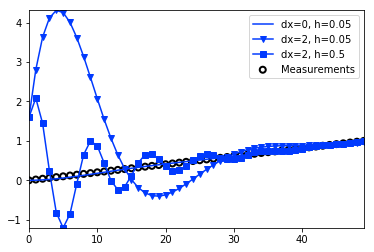

In [4]:
zs = np.linspace(0, 1, 50) # 假设一组测量无噪声的测量值

#对照分析不同参数的GHfilter有着怎么样的初始性能
data1 = g_h_filter(data=zs, x0=0, dx=0., dt=1., g=.2, h=0.05) #初速度为零，恰好与实际速度接近。虽速度修正系数h较小不能快速变化，也不碍整体性能
data2 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.05) #初速度远离于实际速度，速度修正系数h又小，速度难以修正到准确值，整体动态性能差
data3 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.5)  #初速度远离于实际速度，但速度修正系数h大，速度相比较快得到修正，整体动态性能向好

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='dx=0, h=0.05')
book_plots.plot_filter(data2, label='dx=2, h=0.05', marker='v')
book_plots.plot_filter(data3, label='dx=2, h=0.5',  marker='s')
plt.legend(loc=1);


In [24]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/7-JvyzOddTM?list=PL2Fyra_8f6uOliaoz0QBV4rdhfpqPvUGI" frameborder="0" allowfullscreen></iframe>')
